# Info

https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset

# Libraries Import

In [67]:
import glob
import cv2
import tqdm

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
import kagglehub

In [70]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [71]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [73]:
from concurrent.futures import ThreadPoolExecutor

# Constants

In [74]:
IMG_W = 256
IMG_H = 256

BATCH_SIZE = 46

VAL_SPLIT = 0.3

BASE_DIR = r'/kaggle/working/'
# BASE_DIR = ''

# Functions

In [75]:
def save_obj(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# Dataset

In [76]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/edges2shoes-dataset


# Dataset Read

In [77]:
def walk_inside_folder(folder_path):
  EXTENSIONS = ['png', 'jpeg', 'jpg']

  images_paths = []
    
  for root,dirs,files in tqdm.tqdm(os.walk(folder_path)):
    for ext in EXTENSIONS:
      images_paths = images_paths + glob.glob(os.path.join(root,'*.'+ext))
        
  return images_paths


In [78]:
images_paths = walk_inside_folder(dataset_path)

3it [00:18,  6.25s/it]


# Exploration & Visualization

In [79]:
print(f"Total images: {len(images_paths)}")

Total images: 50025


In [80]:
np.random.shuffle(images_paths)
images_paths = images_paths[0:10_000]

In [81]:
for i in range(13):
    print(f"Image[{i:02d}] Shape:", cv2.imread(images_paths[i]).shape)

Image[00] Shape: (256, 512, 3)
Image[01] Shape: (256, 512, 3)
Image[02] Shape: (256, 512, 3)
Image[03] Shape: (256, 512, 3)
Image[04] Shape: (256, 512, 3)
Image[05] Shape: (256, 512, 3)
Image[06] Shape: (256, 512, 3)
Image[07] Shape: (256, 512, 3)
Image[08] Shape: (256, 512, 3)
Image[09] Shape: (256, 512, 3)
Image[10] Shape: (256, 512, 3)
Image[11] Shape: (256, 512, 3)
Image[12] Shape: (256, 512, 3)


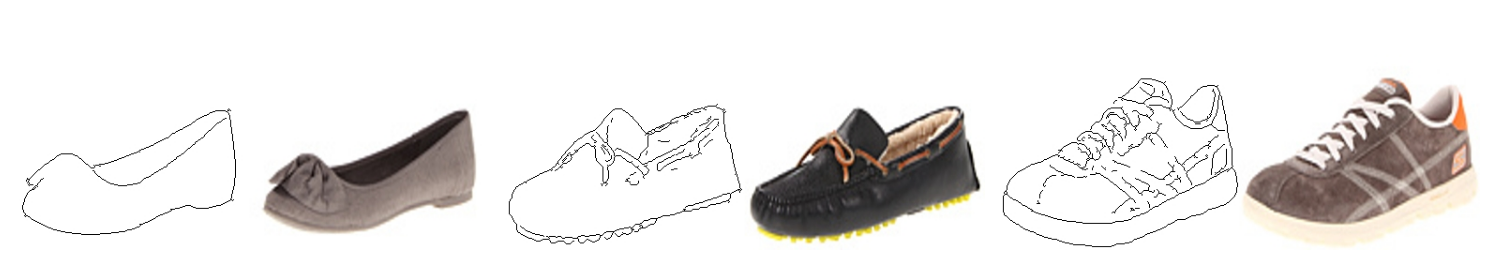

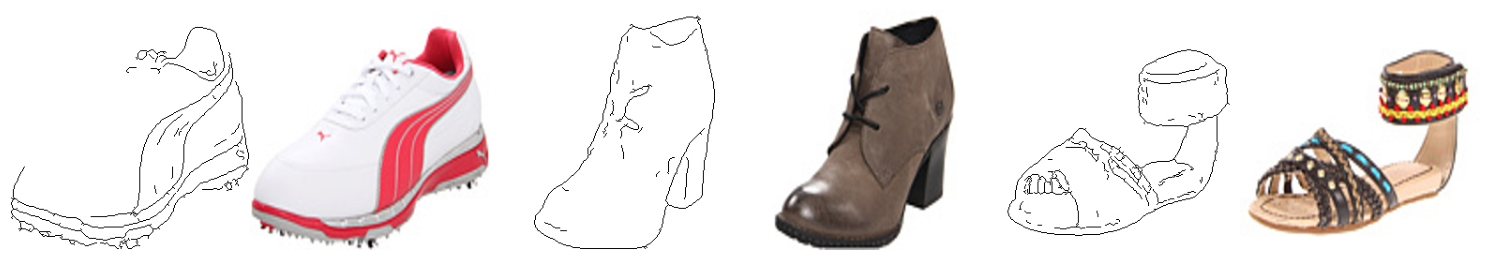

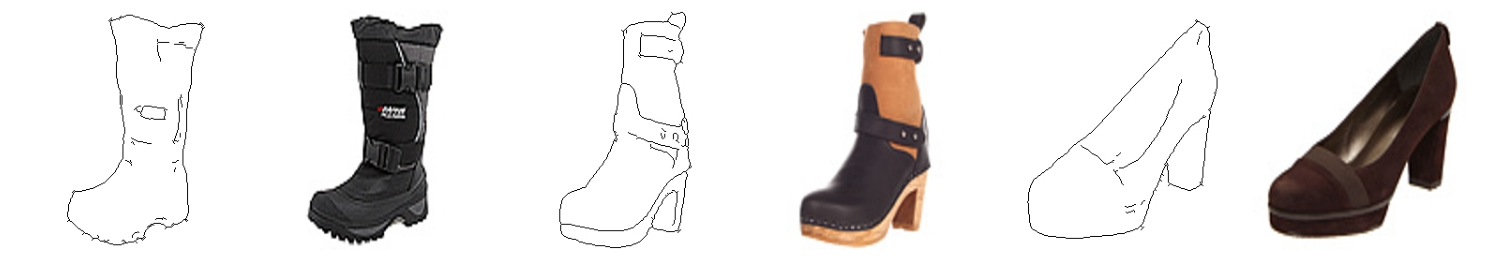

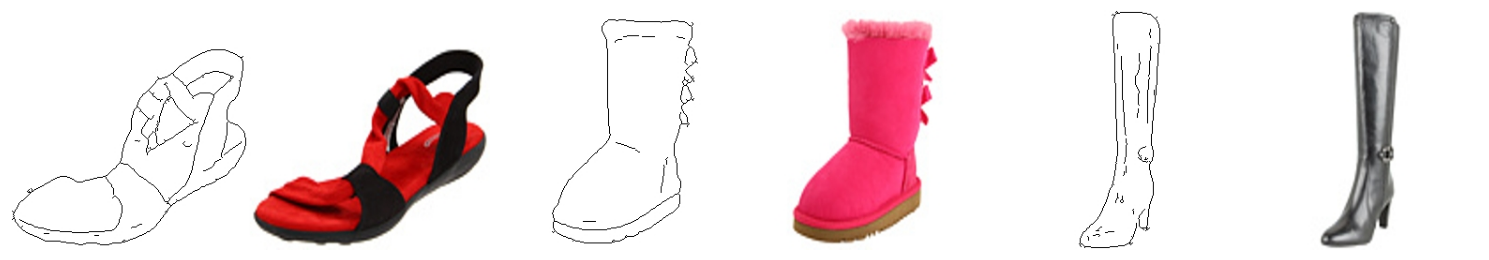

In [82]:
N_ROWS = 4
N_COLS = 3

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, N_COLS, figsize=(15, 15))

    for j in range(N_COLS):
            id_j = np.random.randint(0, len(images_paths))
            img_path_i = images_paths[id_j]
            img_i = cv2.imread(img_path_i, 1)
            img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)

            axs[j].imshow(img_i, cmap='gray')
            axs[j].axis('off')

    fig.tight_layout()
    plt.show()

# Images Preprocessing

Blur Filters

In [83]:
# make image smooth
def apply_filter_gaussian(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma).astype(image.dtype)

# remove salt and pepper noise
def apply_filter_median(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size).astype(image.dtype)

# preserve edges while reducing noise
def apply_filter_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space).astype(image.dtype)

Edge Detection

In [84]:
def apply_canny(image, threshold1=50, threshold2=110):
    return cv2.Canny(image, threshold1, threshold2).astype(image.dtype)

In [85]:
def preprocess_image_from_path(image_path, edge_type = 0):
    image = cv2.imread(image_path, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (2 * IMG_W, IMG_H))

    edge_img = image[:,0:IMG_H]
    shoes_img = image[:,IMG_H:]

    shoes_img = apply_filter_median(shoes_img)
    
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_RGB2GRAY)
    edge_img = np.expand_dims(edge_img, axis=-1)

    shoes_img_grey_img = cv2.cvtColor(shoes_img, cv2.COLOR_RGB2GRAY)
    canny_edges = apply_canny(shoes_img_grey_img)

    shoes_img = (shoes_img / 255.0).astype(np.float32)
    
    edge_img = (edge_img / 255.0).astype(np.float32)
    canny_edges = (canny_edges / 255.0).astype(np.float32)
    
    canny_edges = 1 - canny_edges # swap black and white

    shoes_img = cv2.resize(shoes_img, (IMG_W, IMG_H))
    edge_img = cv2.resize(edge_img, (IMG_W, IMG_H))
    canny_edges = cv2.resize(canny_edges, (IMG_W, IMG_H))

    if len(edge_img.shape) == 2:
        edge_img = np.expand_dims(edge_img, axis = -1)
    
    if len(canny_edges.shape) == 2:
        canny_edges = np.expand_dims(canny_edges, axis = -1)
    
    return [shoes_img, edge_img, canny_edges]

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 0.08627451 1.0 0.0 1.0 0.0


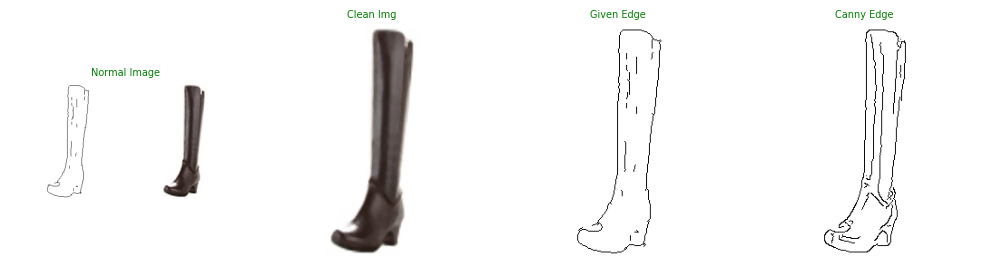

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 0.02745098 1.0 0.0 1.0 0.0


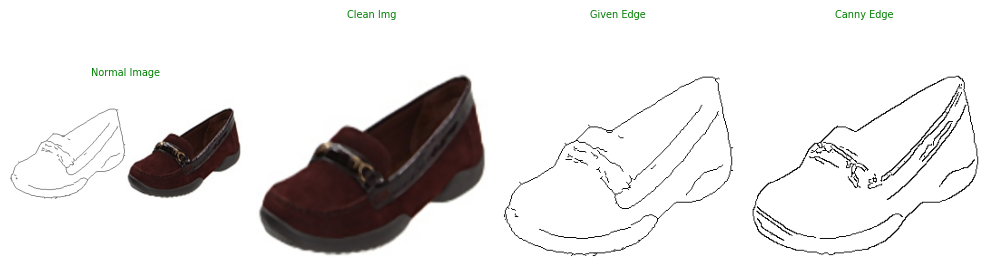

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 0.011764706 1.0 0.0 1.0 0.0


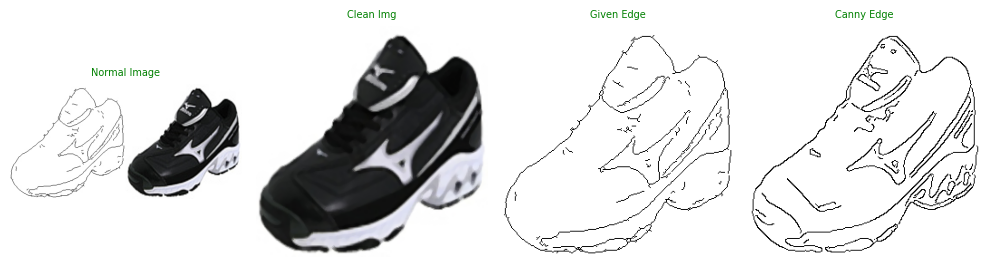

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 0.050980393 1.0 0.0 1.0 0.0


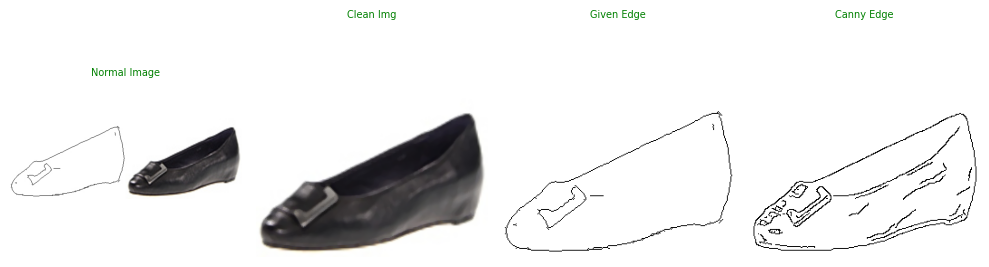

(256, 256, 3) (256, 256, 1) (256, 256, 1) 1.0 0.0 1.0 0.0 1.0 0.0


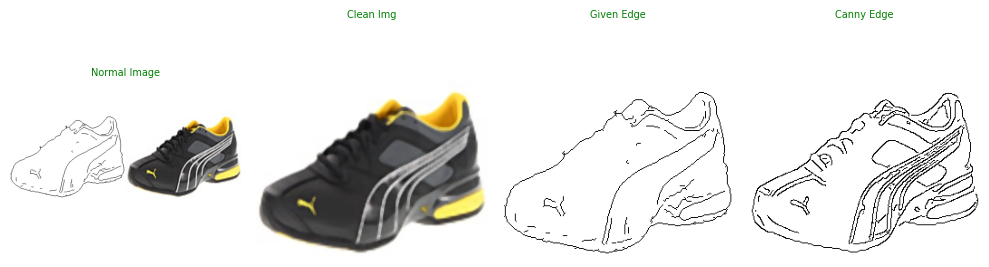

In [86]:
N_ROWS = 5
IMG_SHAPE = None

for i in range(0, N_ROWS):
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    id_j = np.random.randint(0, len(images_paths))
    img_path_i = images_paths[id_j]

    img_i = cv2.imread(img_path_i, 1)
    img_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2RGB)
    img_i_processed, edge_img, canny_img = preprocess_image_from_path(img_path_i)

    print(img_i_processed.shape, edge_img.shape,  canny_img.shape ,np.max(img_i_processed), np.min(img_i_processed), np.max(edge_img), np.min(edge_img), np.max(canny_img), np.min(canny_img))

    axs[0].imshow(img_i.squeeze())
    axs[0].set_title(f"Normal Image", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(img_i_processed)
    axs[1].set_title(f"Clean Img", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(edge_img, cmap='gray')
    axs[2].set_title(f"Given Edge", fontsize=7, color='green')
    axs[2].axis('off')

    axs[3].imshow(canny_img, cmap='gray')
    axs[3].set_title(f"Canny Edge", fontsize=7, color='green')
    axs[3].axis('off')
    
    IMG_SHAPE = img_i_processed.shape

    fig.tight_layout()
    plt.show()

# Data Split

In [87]:
threshold = VAL_SPLIT * len(images_paths)

np.random.shuffle(images_paths)
images_paths_train = images_paths[:-int(threshold)]
images_paths_val = images_paths[-int(threshold):]

In [88]:
print(f"Train images: {len(images_paths_train)}")
print(f"Val images: {len(images_paths_val)}")

Train images: 7000
Val images: 3000


# Data Augmentation

In [89]:
def custom_augmentation_numpy(image, edge_img):
    # -----------------------------
    # 1. Random Horizontal Flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        edge_img = np.fliplr(edge_img)

    # -----------------------------
    # 2. Random Vertical Flip
    # if np.random.rand() > 0.5:
    #     image = np.flipud(image)
    #     edge_img = np.flipud(edge_img)

    # -----------------------------
    # 3. Random Rotation (-15 to 15 degrees)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)
        edge_img = cv2.warpAffine(edge_img, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT_101)

    # -----------------------------
    # 4. Random Crop and Resize Back
    if np.random.rand() > 0.5:
        h, w = image.shape[:2]
        crop_scale = np.random.uniform(0.9, 1.0)
        new_h, new_w = int(h * crop_scale), int(w * crop_scale)
        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)
        image = image[top:top + new_h, left:left + new_w]
        edge_img = edge_img[top:top + new_h, left:left + new_w]
        image = cv2.resize(image, (w, h))
        edge_img = cv2.resize(edge_img, (w, h), interpolation=cv2.INTER_NEAREST)

    # -----------------------------
    # 5. Random Brightness (image only)
    if np.random.rand() > 0.5:
        brightness_shift = np.random.uniform(-0.05, 0.05)
        image = image + brightness_shift
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 6. Random Contrast (image only)
    if np.random.rand() > 0.5:
        factor = np.random.uniform(0.8, 1.2)
        mean = image.mean(axis=(0, 1), keepdims=True)
        image = (image - mean) * factor + mean
        image = np.clip(image, 0, 1)

    # -----------------------------
    # 7. Random Gaussian Noise (image only)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.025, image.shape)
        image = image + noise
        image = np.clip(image, 0, 1)

    if len(edge_img.shape) == 2:
      edge_img = np.expand_dims(edge_img,axis= -1)

    return image, edge_img


In [90]:
class MyDataGenerator(Sequence):
    # Shared cache across all objects of this class
    _shared_image_cache = dict()

    def __init__(self, images_paths, batch_size=32, augment=True, shuffle=True, n_workers=4):
        self.images_paths = np.array(images_paths)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.n_workers = n_workers
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images_paths = self.images_paths[batch_x]

        batch_images_edge_pairs = self._load_images_parallel(batch_images_paths)

        if self.augment:
            batch_images_edge_pairs = [custom_augmentation_numpy(*img) for img in batch_images_edge_pairs]

        return np.array([x[1] for x in batch_images_edge_pairs]), np.array([x[0] for x in batch_images_edge_pairs])

    def on_epoch_end(self):
        self.indices = np.arange(len(self.images_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_images_parallel(self, paths):
        with ThreadPoolExecutor(max_workers=self.n_workers) as executor:
            image_edge_pairs = list(executor.map(self._load_and_preprocess_single, paths))
        return image_edge_pairs

    def _load_and_preprocess_single(self, path):
        if path in MyDataGenerator._shared_image_cache:
            selected_pair =  MyDataGenerator._shared_image_cache[path]
        else:
            image_edge_pair = preprocess_image_from_path(path)
            MyDataGenerator._shared_image_cache[path] = image_edge_pair
            selected_pair =  image_edge_pair

        img, given_edge, canny_edge = selected_pair

        return img, [given_edge, canny_edge][int(np.random.rand() > 0.5)]

    @classmethod
    def clear_cache(cls):
        cls._shared_image_cache.clear()

In [91]:
train_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=True, shuffle=True)

train_pure_generator = MyDataGenerator(images_paths_train, batch_size=BATCH_SIZE, augment=False, shuffle=False)
val_generator = MyDataGenerator(images_paths_val, batch_size=BATCH_SIZE, augment=False, shuffle=False)

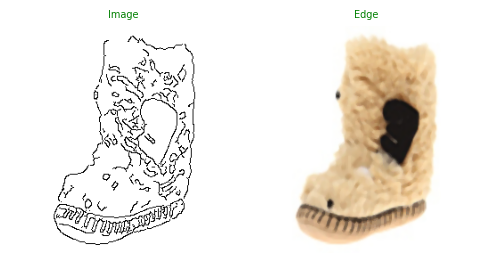

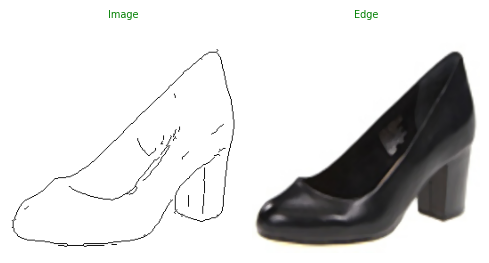

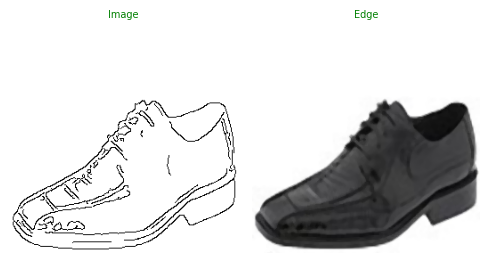

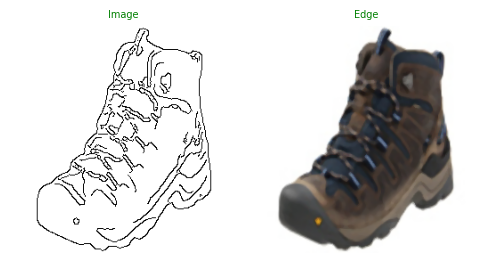

In [92]:
random_batch_x,random_batch_y  = val_generator[0]

for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Image", fontsize=7, color='green')
    axs[0].axis('off')
    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"Edge", fontsize=7, color='green')
    axs[1].axis('off')

    fig.tight_layout()
    plt.show()

# Model Encapsulation

In [93]:
CACHE_MODELS_DIR_NAME = os.path.join(BASE_DIR)
os.makedirs(CACHE_MODELS_DIR_NAME, exist_ok=True)

In [94]:
class CustomModel:
    def __init__(self, name, gen_model, discrim_model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.gen_model = gen_model
        self.discrim_model = discrim_model
        self.trained = False

        # Optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        # Losses
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Track losses
        self.loss_history = {
            "discriminator": [],
            "generator": []
        }

        self.load()

    def l1_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred))

    def generator_loss(self, fake_output, y_true, y_pred, l1_weight=100):
        gan_loss = self.bce(tf.ones_like(fake_output), fake_output)
        l1 = self.l1_loss(y_true, y_pred)
        return gan_loss + l1_weight * l1

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.bce(tf.ones_like(real_output), real_output)
        fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
        return (real_loss + fake_loss) * 0.5

    @tf.function
    def train_step(self, x, y, l1_weight=100):
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            # Generator output
            fake_y = self.gen_model(x, training=True)

            # Discriminator outputs
            real_output = self.discrim_model(y, training=True)
            fake_output = self.discrim_model(fake_y, training=True)

            # Losses
            disc_loss = self.discriminator_loss(real_output, fake_output)
            gen_loss = self.generator_loss(fake_output, y, fake_y, l1_weight)

        # Gradients
        disc_grads = tape.gradient(disc_loss, self.discrim_model.trainable_variables)
        gen_grads = tape.gradient(gen_loss, self.gen_model.trainable_variables)

        # Optimizer steps
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discrim_model.trainable_variables))
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.gen_model.trainable_variables))

        return disc_loss, gen_loss
        
    def fit(self, data_gen, epochs, l1_weight=100, val_data=None):
        for epoch in range(epochs):
            print(f'\nEpoch {epoch + 1}/{epochs}')
            total_d_loss = 0
            total_g_loss = 0
            batches = len(data_gen)
    
            for batch_i in range(batches):
                x_train, y_train = data_gen[batch_i]
    
                d_loss, g_loss = self.train_step(x_train, y_train, l1_weight)
                total_d_loss += d_loss.numpy()
                total_g_loss += g_loss.numpy()
    
                if batch_i % 10 == 0:
                    print(f'Batch {batch_i + 1}/{batches} | D Loss: {d_loss.numpy():.4f} | G Loss: {g_loss.numpy():.4f}')
    
            avg_d_loss = total_d_loss / batches
            avg_g_loss = total_g_loss / batches
    
            self.loss_history["discriminator"].append(avg_d_loss)
            self.loss_history["generator"].append(avg_g_loss)
    
            self.save()
    
            # -------------------------
            # Plot every (1) epochs
            if (epoch + 1) % (1) == 0 and val_data is not None:
                x_val, y_val = val_data[0]
                self.plot_sample_results(x_val[:3], y_val[:3], epoch=epoch+1)
            # -------------------------
    
        self.trained = True


    def load(self):
        g_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5'
        d_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5'
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'

        try:
            self.gen_model.load_weights(g_file_path)
            self.discrim_model.load_weights(d_file_path)
            self.trained = True
            print(f'Loaded weights for {self.name}')
        except Exception as e:
            print(f'No saved weights found for {self.name}, starting fresh.')

        if os.path.exists(loss_file_path):
            with open(loss_file_path, 'r') as f:
                self.loss_history = json.load(f)
            print(f'Loaded loss history for {self.name}')
        else:
            print('No previous loss history found, starting fresh.')

    def save(self):
        # Save weights
        self.gen_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_generator.weights.h5')
        self.discrim_model.save_weights(f'{CACHE_MODELS_DIR_NAME}/{self.name}_discrim.weights.h5')

        # Save loss history
        loss_file_path = f'{CACHE_MODELS_DIR_NAME}/{self.name}_loss.json'
        with open(loss_file_path, 'w') as f:
            json.dump(self.loss_history, f)

        print(f'Saved model and losses for {self.name}')

    def plot_sample_results(self, x_samples, y_samples, epoch):
        preds = self.gen_model.predict(x_samples)
    
        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(f'{self.name} - Epoch {epoch} Sample Predictions', fontsize=16)
    
        for i in range(3):
            edge_img = x_samples[i].squeeze()
            gt_img = y_samples[i]
            pred_img = preds[i]
    
            if edge_img.ndim == 2:
                edge_img = np.stack([edge_img]*3, axis=-1)
    
            axes[i, 0].imshow(edge_img)
            axes[i, 0].set_title('Edge Input')
            axes[i, 1].imshow(gt_img)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 2].imshow((pred_img + 1) / 2)  # assuming tanh [-1, 1]
            axes[i, 2].set_title('Prediction')
    
            for j in range(3):
                axes[i, j].axis('off')
    
        plt.tight_layout()
    
        save_dir = os.path.join(CACHE_MODELS_DIR_NAME, f"{self.name}_plots")
        os.makedirs(save_dir, exist_ok=True)
    
        plt.savefig(os.path.join(save_dir, f"epoch_{epoch}.png"))
        plt.close(fig)


# Models Arch

In [101]:
models_list = list()

In [102]:
def downsample(filters, size, batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=init, use_bias=False))
    if batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result


def upsample(filters, size, dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                                kernel_initializer=init, use_bias=False))
    result.add(BatchNormalization())
    if dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result


def build_gan_model_2():
    global models_list
    NAME = 'gan_deep_v2'

    inputs = Input((IMG_W, IMG_H, 1))
    x = Conv2D(64, 4, strides=1, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)  # Pre-stage

    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv2D(3, 1, activation='sigmoid')(x)

    gen_model = Model(inputs, outputs)
    gen_model.summary()

    # Discriminator (keep the same as your first code)
    disc_in = Input((IMG_H, IMG_W, 3))
    d = Conv2D(64, 4, strides=2, padding='same')(disc_in)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(128, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(256, 4, strides=2, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    d = Conv2D(512, 4, strides=1, padding='same')(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(0.2)(d)

    outputs_disc = Conv2D(1, 4, strides=1, padding='same')(d)

    descrim_model = Model(disc_in, outputs_disc)
    descrim_model.summary()

    # Entire model
    entire_input = Input(shape=(IMG_H, IMG_W, 1))
    gen_output = gen_model(entire_input)
    discrim_output = descrim_model(gen_output)

    entire_model = Model(entire_input, discrim_output)

    custom_model = CustomModel(NAME, gen_model, descrim_model)
    models_list = list(filter(lambda x: x.name != custom_model.name, models_list))
    models_list.append(custom_model)


build_gan_model_2()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 256, 256,  │      1,088 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_42      │ (None, 256, 256,  │          0 │ conv2d_51[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │     65,536 │ leaky_re_lu_42[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │  4,195,328 │ concatenate_12[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 32, 32,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │  1,049,088 │ concatenate_13[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │    262,400 │ concatenate_14[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 128, 128,  │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 128)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 256, 256,  │    131,136 │ concatenate_15[0

 Total params: 16,853,827 (64.29 MB)

 Trainable params: 16,848,963 (64.27 MB)

 Non-trainable params: 4,864 (19.00 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,577 (10.56 MB)

 Trainable params: 2,766,657 (10.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

No saved weights found for gan_deep_v2, starting fresh.
No previous loss history found, starting fresh.


In [103]:
for model in models_list:

        plot_model(
            model.gen_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_gen_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )

        plot_model(
            model.discrim_model,
            to_file=  os.path.join(CACHE_MODELS_DIR_NAME,f'{model.name}_descrim_arch.png'),
            show_shapes=True,
            dpi =200,
            show_layer_names=True,
            expand_nested=True,
            show_layer_activations=True,
            show_trainable=True,
            show_dtype=True,
        )


# Model Training

In [ ]:
for i, model in enumerate(models_list):
    print(f"{i+1}. Train: {model.name}")
    model.fit(train_generator, epochs= 10, val_data = val_generator)
    print('\n')

1. Train: gan_deep_v2

Epoch 1/10


E0000 00:00:1753111398.297346      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_18_1/sequential_5_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 1/153 | D Loss: 0.7851 | G Loss: 40.8777
Batch 11/153 | D Loss: 0.6357 | G Loss: 27.5499
Batch 21/153 | D Loss: 0.5991 | G Loss: 21.4412
Batch 31/153 | D Loss: 0.4218 | G Loss: 19.8216
Batch 41/153 | D Loss: 0.4888 | G Loss: 19.4194
Batch 51/153 | D Loss: 0.4208 | G Loss: 16.6135
Batch 61/153 | D Loss: 0.4292 | G Loss: 15.6835
Batch 71/153 | D Loss: 0.7602 | G Loss: 16.0140
Batch 81/153 | D Loss: 0.5057 | G Loss: 14.1915
Batch 91/153 | D Loss: 0.5009 | G Loss: 14.4598
Batch 101/153 | D Loss: 0.3857 | G Loss: 14.4761
Batch 111/153 | D Loss: 0.5424 | G Loss: 15.1516
Batch 121/153 | D Loss: 0.6360 | G Loss: 14.3846
Batch 131/153 | D Loss: 0.7678 | G Loss: 13.9103


# Model Eval

In [ ]:
TEST_DIR_PATH = os.path.join(BASE_DIR,'test')
os.makedirs(TEST_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y  = val_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i])
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i])
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TEST_DIR_PATH, f'test sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

In [ ]:
TRAIN_DIR_PATH = os.path.join(BASE_DIR,'train')
os.makedirs(TRAIN_DIR_PATH, exist_ok=True)

random_batch_x,random_batch_y = train_pure_generator[0]
random_batch_y_hat = models_list[0].gen_model.predict(random_batch_x)

for i in range(len(random_batch_x)):
    fig, axs = plt.subplots(1, 3, figsize=(5,5))
    axs[0].imshow(random_batch_x[i], cmap='gray')
    axs[0].set_title(f"Edge", fontsize=7, color='green')
    axs[0].axis('off')

    axs[1].imshow(random_batch_y[i], cmap='gray')
    axs[1].set_title(f"True", fontsize=7, color='green')
    axs[1].axis('off')

    axs[2].imshow(random_batch_y_hat[i], cmap='gray')
    axs[2].set_title(f"Predict Image", fontsize=7, color='green')
    axs[2].axis('off')

    fig.tight_layout()
    plt.savefig(os.path.join(TRAIN_DIR_PATH, f'train sample {i}.png'), dpi=300, bbox_inches='tight')  # dpi for quality, bbox_inches to avoid cutoff

# Depolyment